In [1]:
import os
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
import random
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#import tensorflow as tf

from sklearn.metrics import mean_absolute_error #


Github link:
https://github.com/ChZPan/stock-market-prediction-RNN/tree/0470d74adc82c42eed8009d35b5441782eac7806

In [2]:
# Data preperation 
class StockIndexDataset:
    def __init__(self,
                 dataset_files,
                 index_name="SH300IF",
                 batch_size=32,
                 time_steps=12,
                 forecast_steps=0,
                 val_ratio=0.2,
                 test_ratio=0.2,
                 test_only=False,
                 standardization='standard',
                 close_price_only=True):
        self.dataset_files = dataset_files
        self.index_name = index_name
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.forecast_steps = forecast_steps
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.test_only = test_only
        # self.close_price_only = close_price_only
        # self.standardization = standardization

        # Read raw dataset file
        if type(self.dataset_files) is list:
            dfs = []
            for file in self.dataset_files:
                df = pd.read_table(file,delimiter=',',
                                   names=('date', 'time', 'open', 'close', 'volume','ema_5Candle','ema_20Candle','vwap'))   # Used to be the second parameter:delim_whitespace=True
                dfs.append(df)

            self.raw_df = pd.concat(dfs, axis=0, ignore_index=True)
            print("head1",self.raw_df.head())

        else:
            self.raw_df = pd.read_table(self.dataset_files,
                                        delimiter=',',
                                        names=('date', 'time', 'open', 'close', 'volume','ema_5Candle','ema_20Candle','vwap'))  # Used to be the second parameter:delim_whitespace=True
        
        datetime = pd.to_datetime(self.raw_df['date'] + ' ' + self.raw_df['time'])
        print(datetime)
        print("head2",self.raw_df.head())
        #print(self.raw_df.head())
        if close_price_only:
            self.raw_seq = self.raw_df.drop(columns = ['date', 'time', 'open', 'volume','ema_5Candle','ema_20Candle','vwap']).values
        else:
            # Include 'open' in the sequence
            self.raw_seq = self.raw_df.drop(columns = ['date', 'time']).values
            # [price for tup in self.raw_df[['open', 'close']].values for price in tup]

        self.X, self.y, self.datetime = self._prepare_data(self.raw_seq, datetime, 
                                                           self.time_steps, self.forecast_steps,
                                                           self.batch_size, self.val_ratio, self.test_ratio, 
                                                           test_only, standardization)
        if test_only is False:
            [self.X_train, self.X_val, self.X_test] = self.X
            [self.y_train, self.y_val, self.y_test] = self.y
            [self.dtime_train, self.dtime_val, self.dtime_test] = self.datetime
        
        print("Loading dataset... Ready for training.")
    def info(self):
        print("Stock Index Code: {}".format(self.index_name))
        if self.test_only:
            print("Test Set Length: {}".format(self.y.shape))
        else:
            print("Train Set Length: {}\nValidation Set Length: {}\nTest Set Length: {}"
                  .format(self.y_train.shape[0],
                          self.y_val.shape[0],
                          self.y_test.shape[0]))
          
    def _prepare_data(self, raw_seq, raw_dtime, 
                      time_steps, forecast_steps,
                      batch_size, val_ratio, test_ratio, 
                      test_only, standardization):
        if standardization is not None:
            seq = self._standardize(raw_seq, standardization)
        else:
            seq = raw_seq
        
        if test_only:
            X, y, dtime = self._build_timeser(seq, raw_dtime, time_steps, forecast_steps)
            X = self._trim_seq(X, batch_size)
            y = self._trim_seq(y, batch_size)
            dtime = self._trim_seq(dtime, batch_size)

        else:
            temp_X, temp_y, temp_dtime = self._build_timeser(seq, raw_dtime, time_steps, forecast_steps)
            # check the size of xtrain and see if it changes
            X_train, X_test, y_train, y_test, dtime_train, dtime_test = \
            train_test_split(temp_X, temp_y, temp_dtime, test_size=test_ratio, shuffle=False)
            X_train, X_val, y_train, y_val, dtime_train, dtime_val = \
            train_test_split(X_train, y_train, dtime_train, test_size=val_ratio, shuffle=False)
            X = [X_train, X_val, X_test]
            y = [y_train, y_val, y_test]
            dtime = [dtime_train, dtime_val, dtime_test]
            
            for i in range(len(X)):
                X[i] = self._trim_seq(X[i], batch_size)
                y[i] = self._trim_seq(y[i], batch_size)
                dtime[i] = self._trim_seq(dtime[i], batch_size)
        
        return X, y, dtime
    
        
    def _build_timeser(self, seq, dtime, time_steps, forecast_steps):
        dim_0 = seq.shape[0] - (time_steps + forecast_steps)
        dim_1 = seq.shape[1]
        X = np.zeros((dim_0, time_steps, dim_1))

        for i in range(dim_0):
            X[i] = seq[i : i+time_steps]
        y = seq[time_steps+forecast_steps:]
        dt = dtime[time_steps+forecast_steps:]

        return X, y, dt
    
    def _standardize(self, seq, method):
        if ('max' in method) or ('min' in method):
            scaler = MinMaxScaler()
            scaler.fit(seq)
        elif 'stand' in method:
            scaler = StandardScaler()
            scaler.fit(seq)
        seq_scaled = scaler.transform(seq)
        return seq_scaled
    
    def _trim_seq(self, seq, batch_size):
        drop = seq.shape[0] % batch_size
        if drop > 0:
            return seq[:-drop]
        else:
            return seq

In [3]:
# Utils
def plot_seqs(seqs, 
              datetime,
              labels=None, 
              title=None, 
              ylabel=None,
              linewidth=1.0):
    
    plt.figure(figsize=(20, 5))
    
    xticks_loc, years = set_xticks(datetime)
    
    if type(seqs) is list:
        for i, seq in enumerate(seqs):
            if labels is None:
                plt.plot(seq, linewidth=linewidth)
            else:
                plt.plot(seq, label=labels[i], linewidth=linewidth)
    else:
        if labels is None:
            plt.plot(seqs, linewidth=linewidth)
        else:
            plt.plot(seqs, label=labels, linewidth=linewidth)
    
    plt.title(title)
    plt.xlabel('Time')
    plt.xticks(xticks_loc, years, rotation=45)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()
    
    
def set_xticks(datetime):
    year_month = datetime.dt.to_period("M")
    ym_unique = year_month.unique()
    xticks_loc = []
    for ym in ym_unique:
        loc = np.where(year_month == ym)[0][0] + datetime.index[0]
        xticks_loc.append(loc)
    return xticks_loc, ym_unique.astype(str)


def create_labels(labels, val_1, val_2 = None,val_3 = None):
    if type(val_1) is not list:
        val_1 = [val_1]
        val_2 = [val_2]
        val_3 = [val_3]
    #assert len(labels) - len(val_1) == 1, \
    #"Some labels might be missing."

    for i in range(len(labels)): #labels is 4 while there are 4 val_1
        if i == 0:
            labels[i] += " (MSE/ACC/MAPE)"
        else:
            labels[i] = labels[i] \
                        + " (" \
                        + str(round(val_1[i-1], 2)) \
                        + "/" \
                        + str(round(val_2[i-1], 2)) \
                        + "/" \
                        + str(round(val_3[i-1], 2)) \
                        + ")"
    return labels

In [4]:
# RNN Models
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def mape(pred, true):
    if type(pred) is list:
        mape = [K.mean(K.abs((y_hat-y)/y_hat))*100 for y, y_hat in zip(pred, true)]
    else:
        mape= [K.mean(K.abs((true-pred)/true))*100]
    return mape

def mda(y_true, y_pred, t=12):
    d = K.equal(K.sign(y_true[t: ] - y_true[:-t]),
                K.sign(y_pred[t: ] - y_pred[:-t]))
    return K.mean(K.cast(d, K.floatx()))

    

def build_SimpleRNN(input_shape, parameters):
    model = Sequential()
    model.add(SimpleRNN(units=parameters['RNN_size'], batch_input_shape=input_shape,
                        unroll=True, stateful=True))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model

def build_GRU(input_shape, parameters):
    model = Sequential()
    model.add(GRU(units=parameters['RNN_size'], batch_input_shape=input_shape,
                  unroll=True, stateful=True))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model


def build_LSTM(input_shape, parameters):
    model = Sequential()
    model.add(LSTM(units=parameters['RNN_size'], 
                   batch_input_shape=input_shape, 
                   unroll=True, stateful=True))
    model.add(Dropout(parameters['dropout']))
    '''
    model.add(LSTM(units=parameters['RNN_size'], 
                   batch_input_shape=input_shape, 
                   unroll=True, stateful=True,return_sequences=False))
    model.add(Dropout(parameters['dropout']))
    '''
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model
    
def build_bidirectional_LSTM(input_shape, parameters):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=parameters['RNN_size'], 
                                 batch_input_shape=input_shape, 
                                 unroll=True, stateful=True)))
    model.add(Dropout(parameters['dropout']))
    '''
    model.add(Bidirectional(LSTM(units=parameters['RNN_size'], 
                                 batch_input_shape=input_shape, 
                                 unroll=True, stateful=True,return_sequences = False)))
    model.add(Dropout(parameters['dropout']))
    '''
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    optimizer = parameters["optim"](lr = parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, mda,mape])
    return model


def training_callbacks(callback_lsit, params, filepath=None):
    callbacks = []
    if 'mcp' in callback_lsit:
        mcp = ModelCheckpoint(filepath=filepath, 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, save_weights_only=False, 
                              mode='min', period=1)
        callbacks.append(mcp)
        
    if 'csv_logger' in callback_lsit:
        csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 
                                            'training_log_' + time.ctime().replace(" ","_") + '.log'), 
                               append=True)
        callbacks.append(csv_logger)

    if 'es' in callback_lsit:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                           patience = params["earlystop"]["patience"], 
                           min_delta = params["earlystop"]["min_delta"])
        callbacks.append(es)
        
    if 'reduce_lr' in callback_lsit:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor = params["reduce_lr"]["factor"], 
                                      patience = params["reduce_lr"]["patience"],
                                      min_delta = params["reduce_lr"]["min_delta"],
                                      verbose=0, mode='auto' , 
                                      cooldown=0, min_lr=0)
        callbacks.append(reduce_lr)

    return callbacks

    
class ModelPredictions:
    def __init__(self,
                 model,
                 X,
                 y,
                 raw_y,
                 datetime,
                 window = 12,
                 batch_size = 32,
                 stnd_method = "standard"):
        self.__model = model
        self.__X = X
        self.__y = y
        self.__raw_y = raw_y
        self.__datetime = datetime
        self.__window = window
        self.__batch_size = batch_size
        self.__stnd_method = stnd_method

        if type(self.__X) is list:
            self.predictions = []
            self.predictions_org = []
            self.true = []
            self.true_org = []

            assert len(self.__X) == len(self.__y) == len(self.__datetime), \
            "Lists of input samples (X), target variables (y) and timestamp don't match in length!"
            
            start_index = 0
            for x, y in zip(self.__X, self.__y):
                assert x.shape[0] == y.shape[0], \
                "Input sample array (X) does not match target variable array (y)!"
                
                pred = pd.Series(self._predict(x, self.__model, self.__batch_size).reshape(-1),
                                 index = range(start_index, start_index + x.shape[0]))
                true = pd.Series(y.reshape(-1), index = range(start_index, start_index + y.shape[0]))
                pred_org = pd.Series(self._destnd(pred.values.reshape(-1,1),
                                                  self.__raw_y,
                                                  self.__stnd_method)
                                         .reshape(-1),
                                     index = pred.index)
                true_org = pd.Series(self._destnd(true.values.reshape(-1,1),
                                                  self.__raw_y,
                                                  self.__stnd_method)
                                         .reshape(-1),
                                     index = true.index)                                 
                self.predictions.append(pred)
                self.true.append(true)
                self.predictions_org.append(pred_org)
                self.true_org.append(true_org)
                start_index += x.shape[0] 



        else:
            assert X.shape[0] == y.shape[0], \
            "Input sample array (X) does not match target variable array (y)!"
            
            self.predictions = pd.Series(self._predict(self.__X, 
                                                       self.__model, 
                                                       self.__batch_size)
                                             .reshape(-1))
            self.true = pd.Series(self.__y.reshape(-1))
            self.predictions_org = pd.Series(self._destnd(self.predictions.values.reshape(-1,1),
                                                          self.__raw_y,
                                                          self.__stnd_method)
                                                 .reshape(-1))
            self.true_org = pd.Series(self._destnd(self.__y,
                                                   self.__raw_y,
                                                   self.__stnd_method)
                                          .reshape(-1))
     
        
        self.loss = self.cal_mse(self.predictions_org, self.true_org)
        self.rmse = self.cal_rmse(self.predictions_org, self.true_org)
        self.mda = self.cal_mda(self.predictions_org, self.true_org, self.__window)
        self.mape = self.cal_mape(self.predictions_org,self.true_org)
                
    def _predict(self, X, model, batch_size):
        pred = model.predict(X, batch_size)
        return pred
    
    def calculateMAE(self, pred, true):
        return np.abs(np.subtract(true, pred)).mean()
    def _destnd(self, seq_to_destnd, seq_fitting, method):
        if ('max' in method) or ('min' in method):
            scaler = MinMaxScaler()
            scaler.fit(seq_fitting)
        elif 'stand' in method:
            scaler = StandardScaler()
            scaler.fit(seq_fitting)
        seq_destnd = scaler.inverse_transform(seq_to_destnd)
        return seq_destnd
    
    
    def plot_predictions(self, labels=None, title=None, origin=True):
        if labels is not None:
            assert len(labels) - len(self.loss) == 1, \
            "The number of labels does NOT match the number of sequences to plot."

            for i in range(len(labels)):
                if i == 0:
                    labels[i] += " (MSE/ACC)"
                else:
                    labels[i] = labels[i] + " (" + \
                                str(round(self.loss[i-1], 2)) + "/" + \
                                str(round(self.mda[i-1], 2)) + ")"

        if type(self.__X) is list:
            dtime = pd.concat(self.__datetime, axis=0, ignore_index=True)
            if origin:
                true = pd.concat(self.true_org, axis=0, ignore_index=True)
                pred = pd.concat(self.predictions_org, axis=0, ignore_index=False)
                assert (true.index == pred.index).all(), \
                "Predictions does not match target variables!"
                assert (pred.index == dtime.index).all(), \
                "Predictions does not match timestamp!"
                plot_seqs([true]+self.predictions_org, dtime,
                          title=title, labels=labels)
            else:
                true = pd.concat(self.true, axis=0, ignore_index=True)
                pred = pd.concat(self.predictions, axis=0, ignore_index=False)
                assert (true.index == pred.index).all(), \
                "Predictions does not match target variables!"
                assert (pred.index == dtime.index).all(), \
                "Predictions does not match timestamp!"
                plot_seqs([self.true]+self.predictions, dtime,
                          title=title, labels=labels)
        else:
            if origin:
                assert (self.true_org.index == self.predictions_org.index).all(), \
                "Predictions does not match target variables!"
                assert (self.true_org.shape[0] == self.__datetime.shape[0]), \
                "Predictions does not match timestamp!"
                plot_seqs([self.true_org, self.predictions_org],
                          self.__datetime,
                          title=title, labels=labels)
            else:
                assert (self.true.index == self.predictions.index).all(), \
                "Predictions does not match target variables!"
                assert (self.true_org.index == self.__datetime.index), \
                "Predictions does not match timestamp!"
                plot_seqs([self.true, self.predictions], 
                          self.__datetime,
                          title=title, labels=labels)
    def cal_mape(self,pred, true):
      if type(pred) is list:
          mape = [np.mean(np.abs((y_hat-y)/y_hat))*100 for y, y_hat in zip(pred, true)]
      else:
          mape= [np.mean(np.abs((true-pred)/true))*100]
      return mape
    def cal_mse(self, pred, true):
        if type(pred) is list:
            mse = [(y - y_hat).pow(2).mean() for y, y_hat in zip(pred, true)]
        else:
            mse = [(pred - true).pow(2).mean()]
        return mse

    def cal_rmse(self, pred, true):
        if type(pred) is list:
            rmse = [np.sqrt((y - y_hat).pow(2).mean()) for y, y_hat in zip(pred, true)]
        else:
            rmse = [np.sqrt((pred - true).pow(2).mean())]
        return rmse
    
    def cal_mda(self, pred, true, t):
        if type(pred) is list:
            mda = [np.equal(np.sign(y[t::t].values - y[:-t:t].values), 
                            np.sign(y_hat[t::t].values - y_hat[:-t:t].values))
                     .mean() 
                   for y, y_hat in zip(pred, true)]
        else:
            mda = [np.equal(np.sign(pred[t::t].values - pred[:-t:t].values), 
                            np.sign(true[t::t].values - true[:-t:t].values))
                     .mean()]
        return mda        

In [5]:
# Set constant variables and hyper-parameters for the model training

#INPUT_PATH = "/kaggle/input/sh300if"  # OUTPUT_PATH = "/kaggle/output"  
#INPUT_PATH = "Users/levim/Documents/CS436/stock-market-prediction-RNN/stock-market-prediction-RNN/data/"
INPUT_PATH = '/content/data/'

RNN_params = {"batch_size": 32,
              "epochs": 70, # was 120
              "lr": 1e-4,# was 1e-4 
              "time_steps": 12,
              "forecast_steps": 6,
              "window": 48,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

GRU_params = {"batch_size": 32,
              "epochs": 70, # was 120
              "lr": 1e-4  , # was 1e-4 
              "time_steps": 12,
              "forecast_steps": 6,
              "window": 48,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

LSTM_params = {"batch_size": 32,
               "epochs": 70, # was 120
               "lr": 1e-4  , # was 1e-4 
               "time_steps": 12,
               "forecast_steps": 6,
               "window": 48,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": Adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }
BLSTM_params = {"batch_size": 32,
               "epochs": 70, # was 120
               "lr": 1e-4  , # was 1e-4 , use .003 for high epoch 
               "time_steps": 12,
               "forecast_steps": 6,
               "window": 48,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": Adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }

In [6]:
# Load datasets
datasets_path = [os.path.join(INPUT_PATH, file) for file in sorted(os.listdir(INPUT_PATH))]
#datasets_path = INPUT_PATH
#print(datasets_path)
for p in datasets_path:
    print(p)

/content/data/dataTA (1).csv


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Create a StockIndexDataset object for the SimpleRNN network
RNNdata = StockIndexDataset(datasets_path[0], time_steps=RNN_params['time_steps'], 
                            forecast_steps=RNN_params['forecast_steps'],
                            batch_size=RNN_params['batch_size'], val_ratio=.1, test_ratio=0.1)
RNNdata.info()

0       2021-05-14 11:25:00
1       2021-05-14 11:30:00
2       2021-05-14 11:35:00
3       2021-05-14 11:40:00
4       2021-05-14 11:45:00
                ...        
45493   2023-05-03 16:35:00
45494   2023-05-03 16:40:00
45495   2023-05-03 16:45:00
45496   2023-05-03 16:50:00
45497   2023-05-03 16:55:00
Length: 45498, dtype: datetime64[ns]
head2          date      time        open       close  volume  ema_5Candle  \
0  2021-05-14  11:25:00  125.356364  125.267185  801263   125.229354   
1  2021-05-14  11:30:00  125.262335  125.257287  614222   125.231156   
2  2021-05-14  11:35:00  125.257386  125.267284  680334   125.233487   
3  2021-05-14  11:40:00  125.272628  125.292028  696884   125.237264   
4  2021-05-14  11:45:00  125.292028  125.163356  793448   125.232496   

   ema_20Candle        vwap  
0    125.284631  125.326077  
1    125.279659  125.306788  
2    125.277409  125.268947  
3    125.280067  125.269106  
4    125.258847  125.242264  
Loading dataset... Ready for trainin

In [9]:
# Create a StockIndexDataset object for the GRU network
GRUdata = StockIndexDataset(datasets_path[0], time_steps=GRU_params['time_steps'],
                            forecast_steps=GRU_params['forecast_steps'],
                            batch_size=GRU_params['batch_size'], val_ratio=.1, test_ratio=.1)
GRUdata.info()

0       2021-05-14 11:25:00
1       2021-05-14 11:30:00
2       2021-05-14 11:35:00
3       2021-05-14 11:40:00
4       2021-05-14 11:45:00
                ...        
45493   2023-05-03 16:35:00
45494   2023-05-03 16:40:00
45495   2023-05-03 16:45:00
45496   2023-05-03 16:50:00
45497   2023-05-03 16:55:00
Length: 45498, dtype: datetime64[ns]
head2          date      time        open       close  volume  ema_5Candle  \
0  2021-05-14  11:25:00  125.356364  125.267185  801263   125.229354   
1  2021-05-14  11:30:00  125.262335  125.257287  614222   125.231156   
2  2021-05-14  11:35:00  125.257386  125.267284  680334   125.233487   
3  2021-05-14  11:40:00  125.272628  125.292028  696884   125.237264   
4  2021-05-14  11:45:00  125.292028  125.163356  793448   125.232496   

   ema_20Candle        vwap  
0    125.284631  125.326077  
1    125.279659  125.306788  
2    125.277409  125.268947  
3    125.280067  125.269106  
4    125.258847  125.242264  
Loading dataset... Ready for trainin

In [10]:
# Create a StockIndexDataset object for the LSTM network
LSTMdata = StockIndexDataset(datasets_path[0], time_steps=LSTM_params['time_steps'],
                             forecast_steps=LSTM_params['forecast_steps'],
                             batch_size=LSTM_params['batch_size'], val_ratio=.1, test_ratio=.1)
LSTMdata.info()

0       2021-05-14 11:25:00
1       2021-05-14 11:30:00
2       2021-05-14 11:35:00
3       2021-05-14 11:40:00
4       2021-05-14 11:45:00
                ...        
45493   2023-05-03 16:35:00
45494   2023-05-03 16:40:00
45495   2023-05-03 16:45:00
45496   2023-05-03 16:50:00
45497   2023-05-03 16:55:00
Length: 45498, dtype: datetime64[ns]
head2          date      time        open       close  volume  ema_5Candle  \
0  2021-05-14  11:25:00  125.356364  125.267185  801263   125.229354   
1  2021-05-14  11:30:00  125.262335  125.257287  614222   125.231156   
2  2021-05-14  11:35:00  125.257386  125.267284  680334   125.233487   
3  2021-05-14  11:40:00  125.272628  125.292028  696884   125.237264   
4  2021-05-14  11:45:00  125.292028  125.163356  793448   125.232496   

   ema_20Candle        vwap  
0    125.284631  125.326077  
1    125.279659  125.306788  
2    125.277409  125.268947  
3    125.280067  125.269106  
4    125.258847  125.242264  
Loading dataset... Ready for trainin

In [11]:

BLSTMdata = StockIndexDataset(datasets_path[0], time_steps=BLSTM_params['time_steps'],
                             forecast_steps=BLSTM_params['forecast_steps'],
                             batch_size=BLSTM_params['batch_size'], val_ratio=.1, test_ratio=.1)
BLSTMdata.info()

0       2021-05-14 11:25:00
1       2021-05-14 11:30:00
2       2021-05-14 11:35:00
3       2021-05-14 11:40:00
4       2021-05-14 11:45:00
                ...        
45493   2023-05-03 16:35:00
45494   2023-05-03 16:40:00
45495   2023-05-03 16:45:00
45496   2023-05-03 16:50:00
45497   2023-05-03 16:55:00
Length: 45498, dtype: datetime64[ns]
head2          date      time        open       close  volume  ema_5Candle  \
0  2021-05-14  11:25:00  125.356364  125.267185  801263   125.229354   
1  2021-05-14  11:30:00  125.262335  125.257287  614222   125.231156   
2  2021-05-14  11:35:00  125.257386  125.267284  680334   125.233487   
3  2021-05-14  11:40:00  125.272628  125.292028  696884   125.237264   
4  2021-05-14  11:45:00  125.292028  125.163356  793448   125.232496   

   ema_20Candle        vwap  
0    125.284631  125.326077  
1    125.279659  125.306788  
2    125.277409  125.268947  
3    125.280067  125.269106  
4    125.258847  125.242264  
Loading dataset... Ready for trainin

In [12]:
# Build the Simple RNN network
RNN_input = (RNNdata.batch_size, RNNdata.time_steps, RNNdata.X_train.shape[2])
RNN_model = build_SimpleRNN(RNN_input, RNN_params)

# Define callbacks for later model training
# Add 'mcp' keyword into the "callbacks" list for 
# saving the best weights during model traning

RNN_filepath = "RNN_bestweights.hdf5"  
# change to your own working directory for a specific model
# output_dir = os.path.dirname(OUTPUT_PATH)
RNN_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = RNN_params,
                                   filepath = RNN_filepath)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# Build the Rnn network with GRU units
GRU_input = (GRUdata.batch_size, GRUdata.time_steps, GRUdata.X_train.shape[2])
GRU_model = build_GRU(GRU_input, GRU_params)

GRU_filepath = "GRU_bestweights.hdf5"  
# change to your own working directory for a specific model
GRU_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = GRU_params,
                                   filepath = GRU_filepath)

In [14]:
# Build the Rnn network with LSTM units
LSTM_input = (LSTMdata.batch_size, LSTMdata.time_steps, LSTMdata.X_train.shape[2])
LSTM_model = build_LSTM(LSTM_input, LSTM_params)

LTSM_filepath = "LSTM_bestweights.hdf5"  
# change to your own working directory for a specific model
LSTM_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = LSTM_params,
                               filepath = LTSM_filepath)

In [15]:


# Build the Rnn network with BLSTM units
BLSTM_input = (BLSTMdata.batch_size, BLSTMdata.time_steps, BLSTMdata.X_train.shape[2])
BLSTM_model = build_bidirectional_LSTM(BLSTM_input, BLSTM_params)

BLTSM_filepath = "BLSTM_bestweights.hdf5"  
# change to your own working directory for a specific model
BLSTM_callbacks = training_callbacks(['reduce_lr', 'mcp'], params = BLSTM_params,
                               filepath = BLTSM_filepath)

In [16]:
%%time
# Train Simple RNN model
RNN_hist = RNN_model.fit(RNNdata.X_train, RNNdata.y_train, 
                         epochs=RNN_params["epochs"], batch_size=RNNdata.batch_size,
                         shuffle=False, validation_data=(RNNdata.X_val, RNNdata.y_val), 
                         verbose=2, callbacks=RNN_callbacks)

Epoch 1/70

Epoch 1: val_loss improved from inf to 0.01314, saving model to RNN_bestweights.hdf5
1151/1151 - 8s - loss: 0.1323 - rmse: 0.2039 - mda: 0.5159 - mape: 102.9371 - val_loss: 0.0131 - val_rmse: 0.0936 - val_mda: 0.5705 - val_mape: 102.4423 - lr: 1.0000e-04 - 8s/epoch - 7ms/step
Epoch 2/70

Epoch 2: val_loss improved from 0.01314 to 0.00877, saving model to RNN_bestweights.hdf5
1151/1151 - 6s - loss: 0.0294 - rmse: 0.1209 - mda: 0.5251 - mape: 43.9114 - val_loss: 0.0088 - val_rmse: 0.0765 - val_mda: 0.5906 - val_mape: 72.4740 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 3/70

Epoch 3: val_loss improved from 0.00877 to 0.00550, saving model to RNN_bestweights.hdf5
1151/1151 - 7s - loss: 0.0209 - rmse: 0.1033 - mda: 0.5367 - mape: 36.3943 - val_loss: 0.0055 - val_rmse: 0.0570 - val_mda: 0.6028 - val_mape: 57.7642 - lr: 1.0000e-04 - 7s/epoch - 6ms/step
Epoch 4/70

Epoch 4: val_loss improved from 0.00550 to 0.00509, saving model to RNN_bestweights.hdf5
1151/1151 - 5s - loss: 0.017

In [17]:
%%time
# Train Simple GRU model
GRU_hist = GRU_model.fit(GRUdata.X_train, GRUdata.y_train, 
                         epochs=GRU_params["epochs"], batch_size=GRUdata.batch_size,
                         shuffle=False, validation_data=(GRUdata.X_val, GRUdata.y_val), 
                         verbose=2, callbacks=GRU_callbacks)

Epoch 1/70

Epoch 1: val_loss improved from inf to 0.00490, saving model to GRU_bestweights.hdf5
1151/1151 - 17s - loss: 0.1653 - rmse: 0.2172 - mda: 0.5257 - mape: 208.9767 - val_loss: 0.0049 - val_rmse: 0.0499 - val_mda: 0.5913 - val_mape: 40.8028 - lr: 1.0000e-04 - 17s/epoch - 15ms/step
Epoch 2/70

Epoch 2: val_loss improved from 0.00490 to 0.00382, saving model to GRU_bestweights.hdf5
1151/1151 - 14s - loss: 0.0211 - rmse: 0.1018 - mda: 0.5347 - mape: 22.2795 - val_loss: 0.0038 - val_rmse: 0.0428 - val_mda: 0.5984 - val_mape: 36.9232 - lr: 1.0000e-04 - 14s/epoch - 13ms/step
Epoch 3/70

Epoch 3: val_loss did not improve from 0.00382
1151/1151 - 15s - loss: 0.0163 - rmse: 0.0905 - mda: 0.5371 - mape: 22.2625 - val_loss: 0.0039 - val_rmse: 0.0436 - val_mda: 0.6035 - val_mape: 52.8673 - lr: 1.0000e-04 - 15s/epoch - 13ms/step
Epoch 4/70

Epoch 4: val_loss did not improve from 0.00382
1151/1151 - 15s - loss: 0.0144 - rmse: 0.0855 - mda: 0.5401 - mape: 33.3008 - val_loss: 0.0040 - val_rms

In [18]:
%%time
# Train LSTM model
LSTM_hist = LSTM_model.fit(LSTMdata.X_train, LSTMdata.y_train, 
                          epochs=LSTM_params["epochs"], batch_size=LSTMdata.batch_size,
                          shuffle=False, validation_data=(LSTMdata.X_val, LSTMdata.y_val), 
                          verbose=2, callbacks=LSTM_callbacks)

Epoch 1/70

Epoch 1: val_loss improved from inf to 0.00614, saving model to LSTM_bestweights.hdf5
1151/1151 - 23s - loss: 0.1336 - rmse: 0.1906 - mda: 0.5131 - mape: 192.2430 - val_loss: 0.0061 - val_rmse: 0.0595 - val_mda: 0.5602 - val_mape: 55.8480 - lr: 1.0000e-04 - 23s/epoch - 20ms/step
Epoch 2/70

Epoch 2: val_loss improved from 0.00614 to 0.00500, saving model to LSTM_bestweights.hdf5
1151/1151 - 19s - loss: 0.0219 - rmse: 0.1049 - mda: 0.5166 - mape: 30.2807 - val_loss: 0.0050 - val_rmse: 0.0507 - val_mda: 0.5681 - val_mape: 41.1848 - lr: 1.0000e-04 - 19s/epoch - 17ms/step
Epoch 3/70

Epoch 3: val_loss did not improve from 0.00500
1151/1151 - 19s - loss: 0.0175 - rmse: 0.0951 - mda: 0.5209 - mape: 36.4020 - val_loss: 0.0050 - val_rmse: 0.0504 - val_mda: 0.5752 - val_mape: 88.0176 - lr: 1.0000e-04 - 19s/epoch - 16ms/step
Epoch 4/70

Epoch 4: val_loss did not improve from 0.00500
1151/1151 - 21s - loss: 0.0158 - rmse: 0.0911 - mda: 0.5318 - mape: 50.3937 - val_loss: 0.0054 - val_r

In [19]:
# Train BLSTM model
BLSTM_hist = BLSTM_model.fit(BLSTMdata.X_train, BLSTMdata.y_train, 
                          epochs=LSTM_params["epochs"], batch_size=BLSTMdata.batch_size,
                          shuffle=False, validation_data=(BLSTMdata.X_val, BLSTMdata.y_val), 
                          verbose=2, callbacks=BLSTM_callbacks)

Epoch 1/70

Epoch 1: val_loss improved from inf to 0.00598, saving model to BLSTM_bestweights.hdf5
1151/1151 - 35s - loss: 0.0852 - rmse: 0.1490 - mda: 0.5078 - mape: 74.0259 - val_loss: 0.0060 - val_rmse: 0.0573 - val_mda: 0.5630 - val_mape: 47.6251 - lr: 1.0000e-04 - 35s/epoch - 30ms/step
Epoch 2/70

Epoch 2: val_loss improved from 0.00598 to 0.00527, saving model to BLSTM_bestweights.hdf5
1151/1151 - 30s - loss: 0.0158 - rmse: 0.0911 - mda: 0.5187 - mape: 25.4920 - val_loss: 0.0053 - val_rmse: 0.0521 - val_mda: 0.5654 - val_mape: 52.0347 - lr: 1.0000e-04 - 30s/epoch - 26ms/step
Epoch 3/70

Epoch 3: val_loss did not improve from 0.00527
1151/1151 - 31s - loss: 0.0129 - rmse: 0.0824 - mda: 0.5236 - mape: 36.1852 - val_loss: 0.0055 - val_rmse: 0.0534 - val_mda: 0.5728 - val_mape: 1694.5466 - lr: 1.0000e-04 - 31s/epoch - 27ms/step
Epoch 4/70

Epoch 4: val_loss did not improve from 0.00527
1151/1151 - 31s - loss: 0.0115 - rmse: 0.0785 - mda: 0.5262 - mape: 47.9602 - val_loss: 0.0055 - va

In [20]:
# Create a ModelPredictions object containing results from the Simple RNN model 
RNN_predictions = ModelPredictions(RNN_model, 
                                   X = RNNdata.X, 
                                   y = RNNdata.y, 
                                   raw_y = RNNdata.raw_seq, 
                                   datetime = RNNdata.datetime,
                                   window = RNN_params['window'],
                                   batch_size = RNN_params['batch_size'])

142/142 [==============================] - 1s 4ms/step


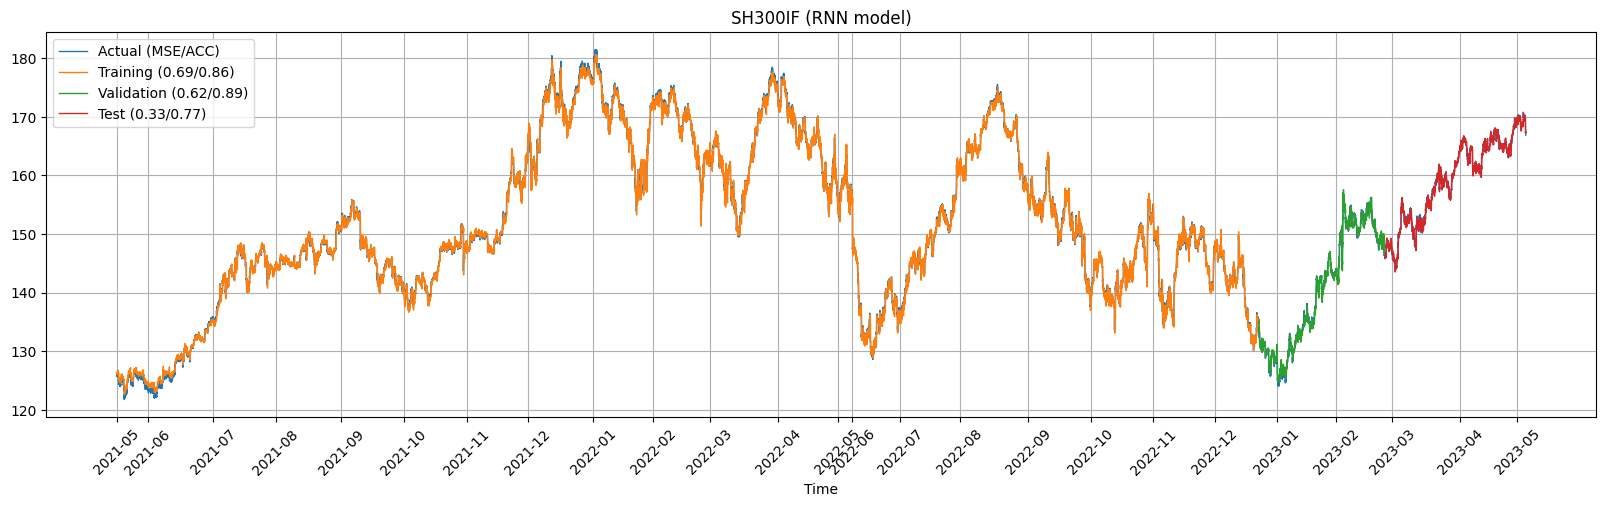

In [21]:
# Plot the results on training, validation and test data sets for Simple RNN model
labels = ['Actual', 'Training', 'Validation', 'Test']
RNN_predictions.plot_predictions(title="SH300IF (RNN model)", labels=labels)
pred_arr = np.array(RNN_predictions.predictions_org)
true_arr = np.array(RNN_predictions.true_org)
#print(type(pred_arr))
#print(type(true_arr))
print(RNN_predictions.mape)
print(RNN_predictions.rmse)



In [22]:
# Create a ModelPredictions object containing results from the GRU model 
GRU_predictions = ModelPredictions(GRU_model, 
                                   X = GRUdata.X, 
                                   y = GRUdata.y, 
                                   raw_y = GRUdata.raw_seq, 
                                   datetime = GRUdata.datetime,
                                   window = GRU_params['window'],
                                   batch_size = GRU_params['batch_size'])

[0.3828016792185693, 0.39642095613335177, 0.2631424669895723]
[0.8306577442415495, 0.7883442831336697, 0.5777327367124816]


<ipython-input-21-85473a355a31>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_arr = np.array(RNN_predictions.predictions_org)
<ipython-input-21-85473a355a31>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  true_arr = np.array(RNN_predictions.true_org)


142/142 [==============================] - 1s 5ms/step


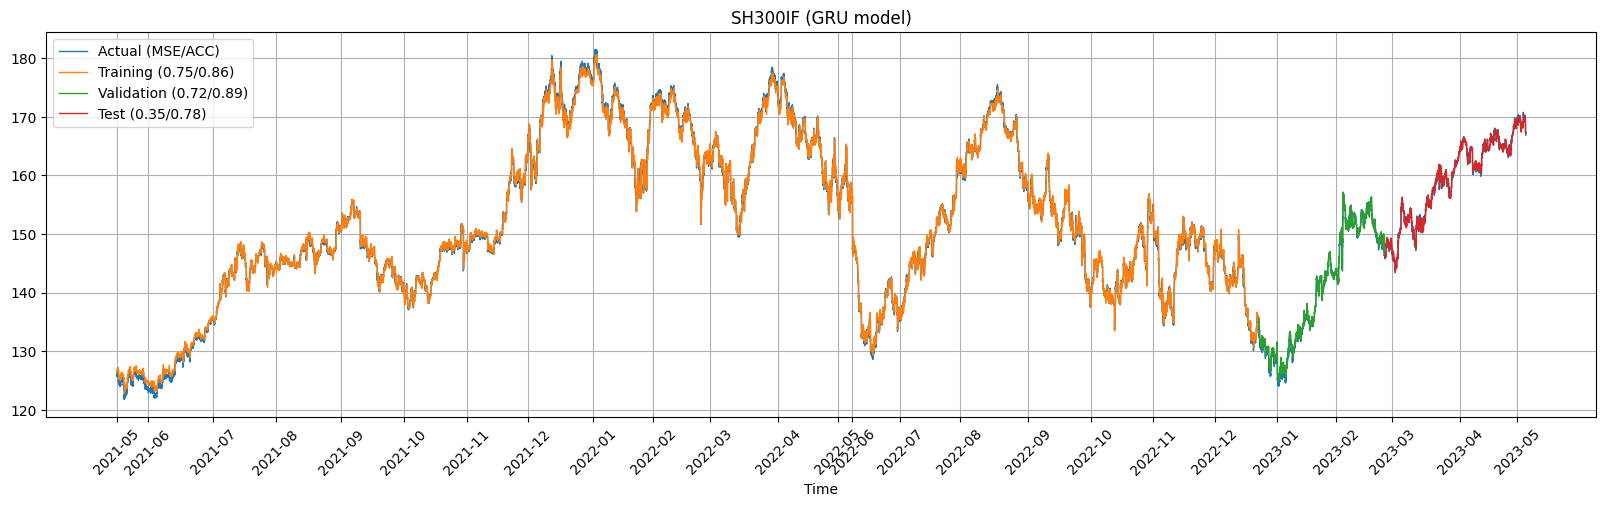

[0.4085996124115473, 0.4320338012724436, 0.2728917850209217]
[0.8646481971402874, 0.8461050605538379, 0.5898649679209204]


In [23]:
# Plot the results on training, validation and test data sets for RNN-GRU model
labels = ['Actual', 'Training', 'Validation', 'Test']
GRU_predictions.plot_predictions(title="SH300IF (GRU model)", labels=labels)
print(GRU_predictions.mape)
print(GRU_predictions.rmse)

In [24]:
# Create a ModelPredictions object containing results from the LSTM model 
LSTM_predictions = ModelPredictions(LSTM_model, 
                                    X = LSTMdata.X, 
                                    y = LSTMdata.y, 
                                    raw_y = LSTMdata.raw_seq, 
                                    datetime = LSTMdata.datetime,
                                    window = LSTM_params['window'],
                                    batch_size = LSTM_params['batch_size'])

142/142 [==============================] - 1s 7ms/step


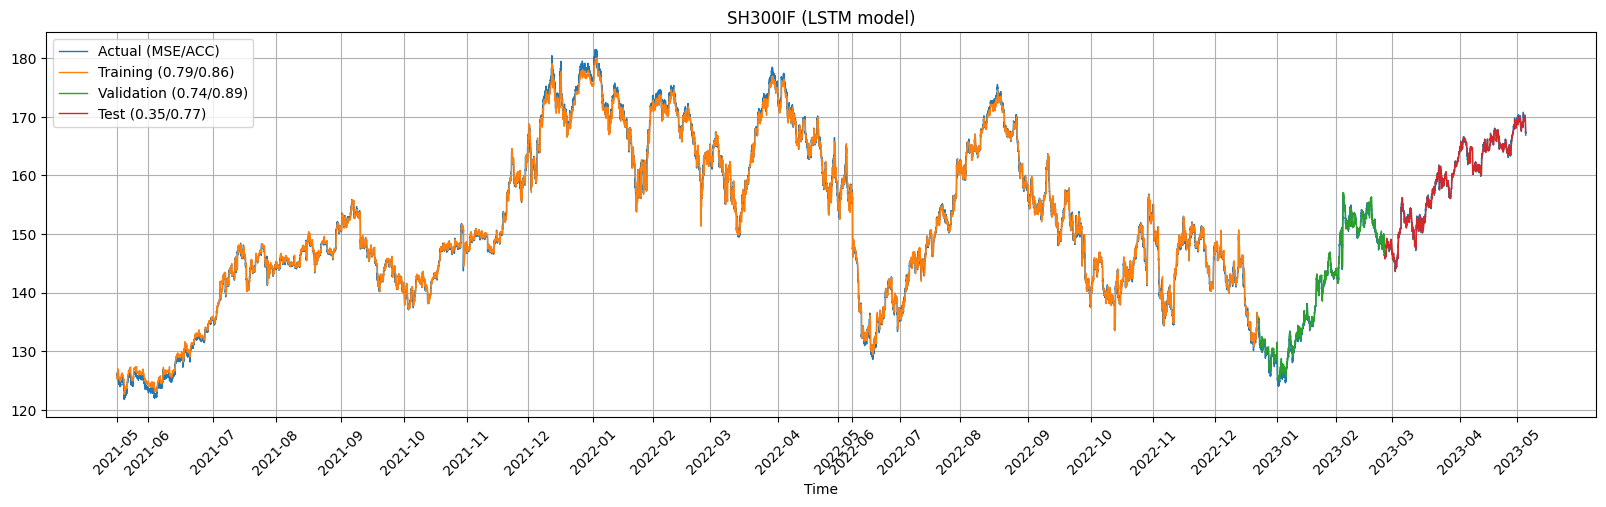

[0.41459724343680765, 0.43099530944058034, 0.26742043664677084]
[0.8896350236880101, 0.8588521569811146, 0.5877192132033108]


In [25]:
# Plot the results on training, validation and test data sets for RNN-LSTM model
labels = ['Actual', 'Training', 'Validation', 'Test']
LSTM_predictions.plot_predictions(title="SH300IF (LSTM model)", labels=labels)
print(LSTM_predictions.mape)
print(LSTM_predictions.rmse)

In [26]:
# Create a ModelPredictions object containing results from the BLSTM model 
BLSTM_predictions = ModelPredictions(BLSTM_model, 
                                    X = BLSTMdata.X, 
                                    y = BLSTMdata.y, 
                                    raw_y = BLSTMdata.raw_seq, 
                                    datetime = BLSTMdata.datetime,
                                    window = BLSTM_params['window'],
                                    batch_size = BLSTM_params['batch_size'])

142/142 [==============================] - 3s 18ms/step


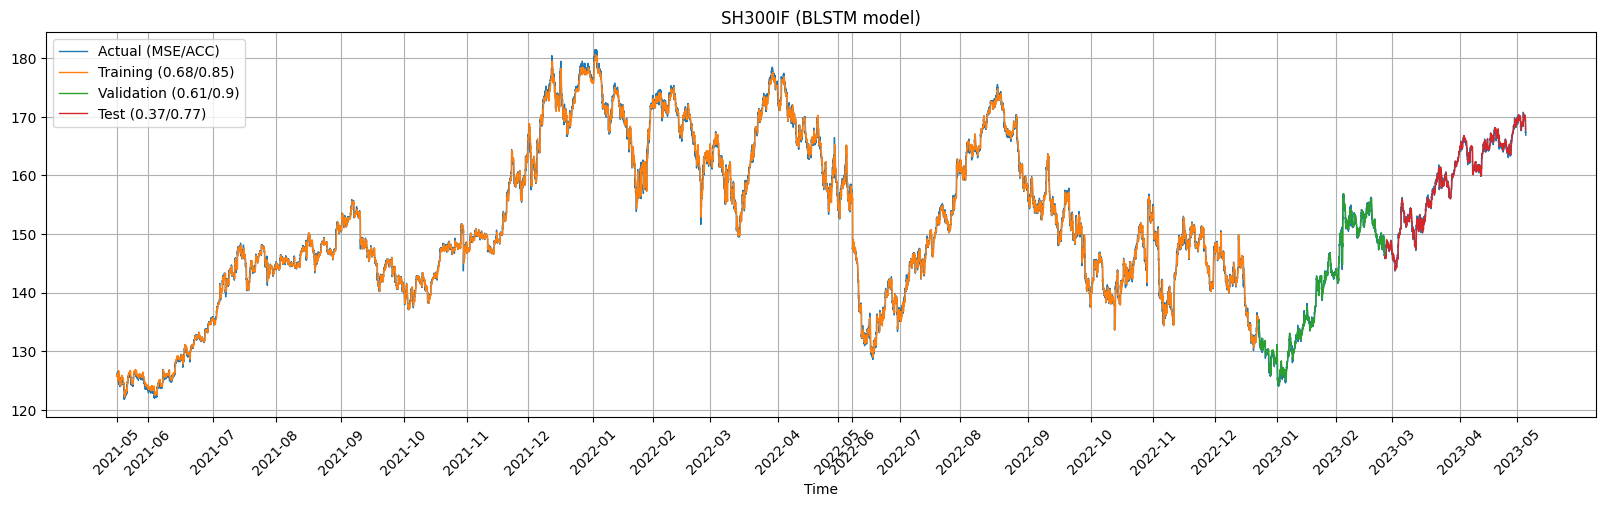

In [27]:
labels = ['Actual', 'Training', 'Validation', 'Test']
BLSTM_predictions.plot_predictions(title="SH300IF (BLSTM model)", labels=labels)

['Actual (MSE/ACC/MAPE)', 'RNN (0.33/0.77/0.26)', 'GRU (0.35/0.78/0.27)', 'LSTM (0.35/0.77/0.27)', 'BLSTM (0.37/0.77/0.28)']


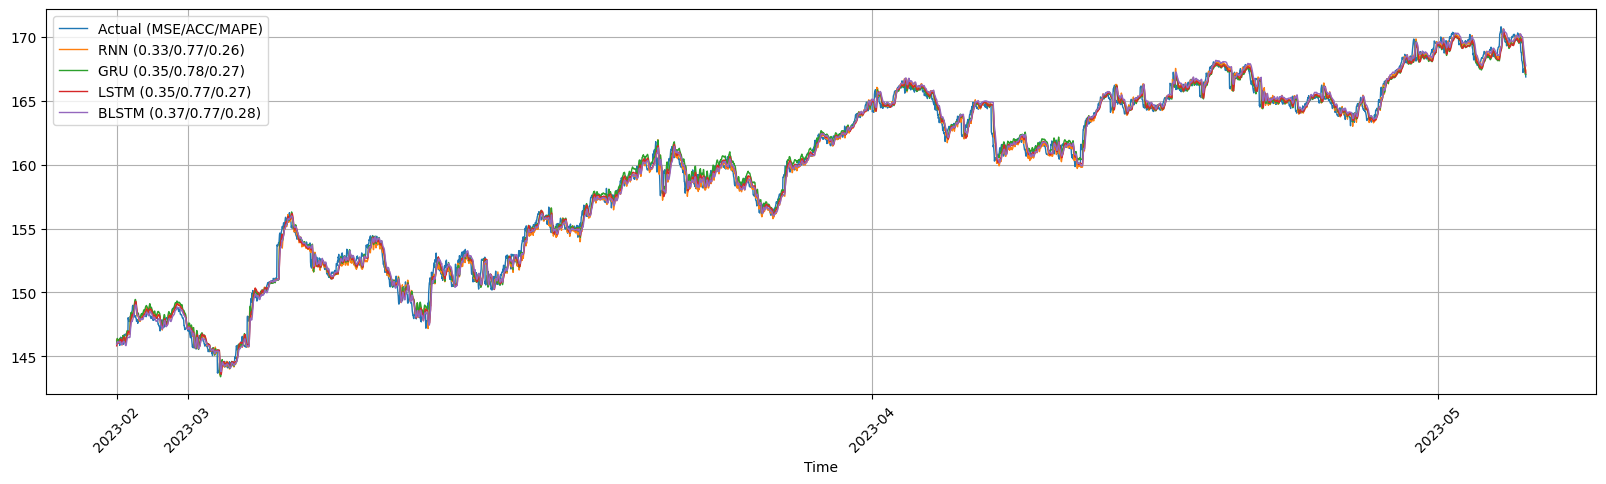

In [28]:
# Plot and compare the results obtained from the three RNNs on the test data set
testset = [RNN_predictions.true_org[2], 
           RNN_predictions.predictions_org[2],
           GRU_predictions.predictions_org[2],
           LSTM_predictions.predictions_org[2],
           BLSTM_predictions.predictions_org[2]]
datetime = pd.Series(RNNdata.datetime[2].values, 
                     index = RNN_predictions.true_org[2].index)
labels = ['Actual', 'RNN', 'GRU', 'LSTM','BLSTM']
list_mse = [RNN_predictions.loss[2],
       GRU_predictions.loss[2],
       LSTM_predictions.loss[2],
      BLSTM_predictions.loss[2]]
list_mda = [RNN_predictions.mda[2],
       GRU_predictions.mda[2],
       LSTM_predictions.mda[2],
       BLSTM_predictions.mda[2]]
list_mape = [RNN_predictions.mape[2],
       GRU_predictions.mape[2],
       LSTM_predictions.mape[2],
       BLSTM_predictions.mape[2]]

labels_loss = create_labels(labels, list_mse, list_mda,list_mape)
print(labels_loss)
plot_seqs(testset, datetime=datetime, labels=labels_loss)

In [29]:
# Load previously saved models, including architecture, weights and optimizer states
dependencies = {'rmse': rmse,
                'mda': mda}
saved_RNN = load_model(RNN_filepath, custom_objects=dependencies)

In [30]:
# Create a StockIndexDataset object that contains new data for testing the SimpleRNN network
# Create the object with the key "test_only=True"

test_data = StockIndexDataset(datasets_path[-1], time_steps=RNN_params['time_steps'], 
                              forecast_steps=RNN_params['forecast_steps'],
                              batch_size=RNN_params['batch_size'], test_only=True)
test_data.info()

0       2021-05-14 11:25:00
1       2021-05-14 11:30:00
2       2021-05-14 11:35:00
3       2021-05-14 11:40:00
4       2021-05-14 11:45:00
                ...        
45493   2023-05-03 16:35:00
45494   2023-05-03 16:40:00
45495   2023-05-03 16:45:00
45496   2023-05-03 16:50:00
45497   2023-05-03 16:55:00
Length: 45498, dtype: datetime64[ns]
head2          date      time        open       close  volume  ema_5Candle  \
0  2021-05-14  11:25:00  125.356364  125.267185  801263   125.229354   
1  2021-05-14  11:30:00  125.262335  125.257287  614222   125.231156   
2  2021-05-14  11:35:00  125.257386  125.267284  680334   125.233487   
3  2021-05-14  11:40:00  125.272628  125.292028  696884   125.237264   
4  2021-05-14  11:45:00  125.292028  125.163356  793448   125.232496   

   ema_20Candle        vwap  
0    125.284631  125.326077  
1    125.279659  125.306788  
2    125.277409  125.268947  
3    125.280067  125.269106  
4    125.258847  125.242264  
Loading dataset... Ready for trainin

In [31]:
# Create a ModelPredictions object containing results of the Simple RNN model on the test data set 
RNN_test = ModelPredictions(saved_RNN, 
                            X = test_data.X, 
                            y = test_data.y, 
                            raw_y = test_data.raw_seq, 
                            datetime = test_data.datetime,
                            window = RNN_params['window'],
                            batch_size = RNN_params['batch_size'])


1421/1421 [==============================] - 4s 2ms/step


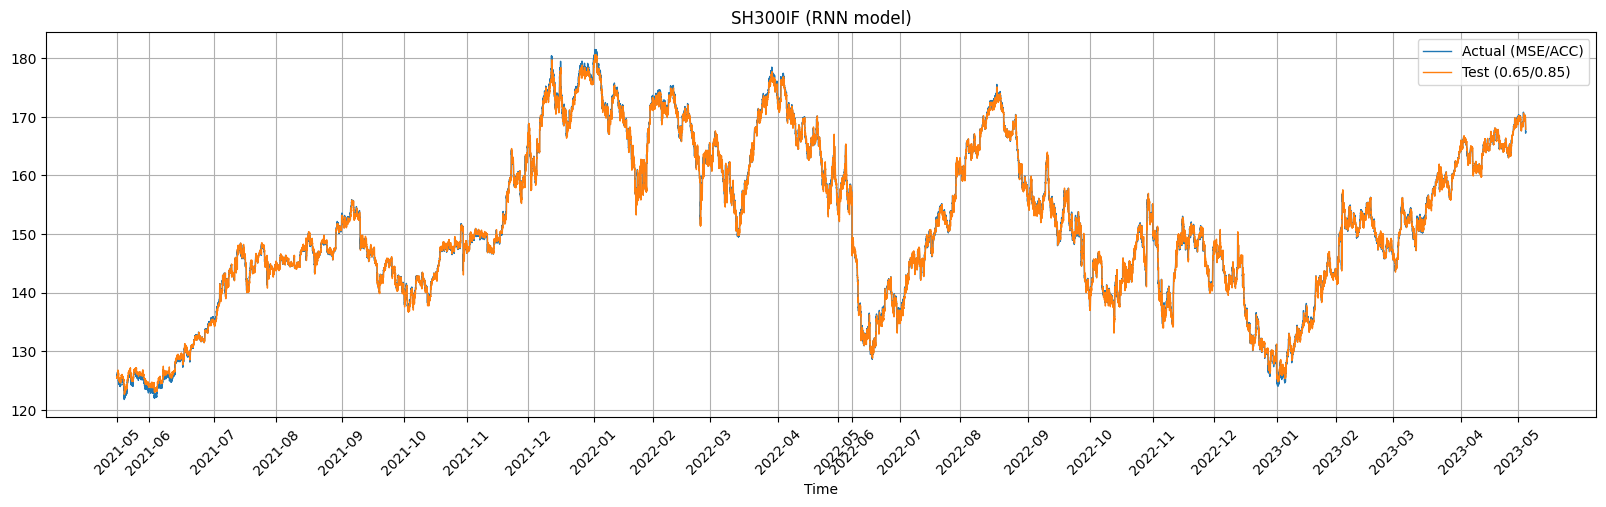

In [32]:
# Plot the testing results
labels = ['Actual', 'Test']
RNN_test.plot_predictions(title="SH300IF (RNN model)", labels=labels)